Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
# visualize model architecture
import visualkeras
from PIL import ImageFont
from tensorflow.keras.utils import plot_model
from datetime import datetime
import pandas as pd
import os, time, warnings
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import requests

API_KEY = 'ei_b8a8b4d0e888f91b15b49d8259017cf947bf6a583d68f079903e1b61251990a1'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/89974/training/90/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/89974/training/90/y')


Store the data in a temporary file, and load it back through Numpy.

In [3]:
with open('dataset/mlp2_x_train.npy', 'wb') as file:
    file.write(X)
with open('dataset/mlp2_y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('dataset/mlp2_x_train.npy')
Y = np.load('dataset/mlp2_y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [4]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Train the model:

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
EPOCHS = 100
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 40), 40), input_shape=(input_length, )))
model.add(Flatten())
model.add(Dense(128, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))

model.add(Dense(128, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))

model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dropout(0.5))
model.add(Dense(classes, name='y_pred', activation='softmax'))
model.summary()

# this controls the learning rate
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 61, 40)            0         
                                                                 
 flatten (Flatten)           (None, 2440)              0         
                                                                 
 dense (Dense)               (None, 128)               312448    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 y_pred (Dense)              (None, 5)                 3

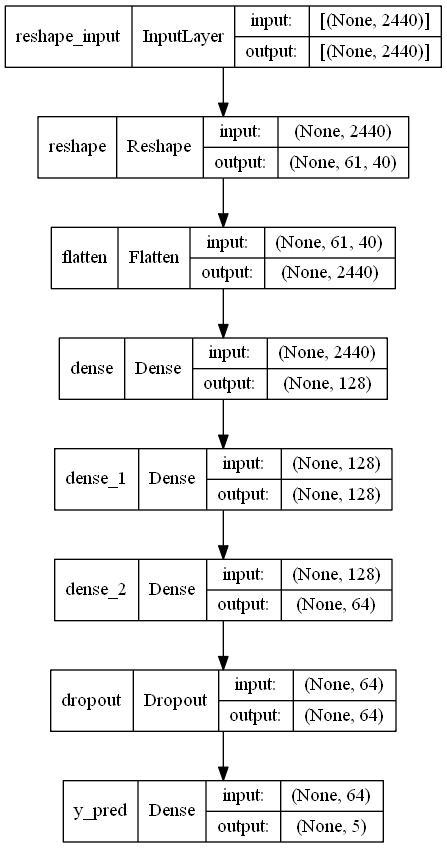

In [6]:
#plot model deep learning
plot_model(model, to_file="model/model-conv1D-architecture.png", show_shapes=True)

In [7]:
filename='log/log_mlp.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [8]:
# time calculation
start = datetime.now()
t0 = time.time()

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
mlp_history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

train_hist_m1 = pd.DataFrame(mlp_history.history)

train_m1 = round(time.time() - t0, 3)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
112/112 - 1s - loss: 1.4766 - accuracy: 0.3571 - val_loss: 1.1069 - val_accuracy: 0.6315 - 1s/epoch - 11ms/step
Epoch 2/100
112/112 - 0s - loss: 1.0029 - accuracy: 0.6460 - val_loss: 0.8156 - val_accuracy: 0.6685 - 368ms/epoch - 3ms/step
Epoch 3/100
112/112 - 0s - loss: 0.6665 - accuracy: 0.7739 - val_loss: 0.4042 - val_accuracy: 0.8652 - 358ms/epoch - 3ms/step
Epoch 4/100
112/112 - 0s - loss: 0.4650 - accuracy: 0.8366 - val_loss: 0.3944 - val_accuracy: 0.8596 - 362ms/epoch - 3ms/step
Epoch 5/100
112/112 - 0s - loss: 0.4693 - accuracy: 0.8324 - val_loss: 0.3174 - val_accuracy: 0.8753 - 380ms/epoch - 3ms/step
Epoch 6/100
112/112 - 0s - loss: 0.3466 - accuracy: 0.8816 - val_loss: 0.2920 - val_accuracy: 0.8899 - 356ms/epoch - 3ms/step
Epoch 7/100
112/112 - 0s - loss: 0.3244 - accuracy: 0.8830 - val_loss: 0.2548 - val_accuracy: 0.8910 - 363ms/epoch - 3ms/step
Epoch 8/100
112/112 - 0s - loss: 0.2954 - accuracy: 0.8988 - val_loss: 0.3099 - val_accuracy: 0.8663 - 369ms/epoch - 3ms

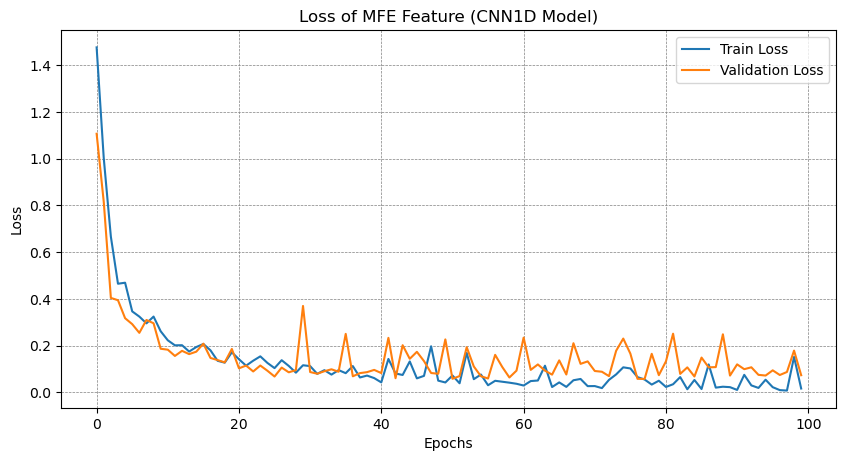

In [9]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["loss", "val_loss"]])
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss of MFE Feature (CNN1D Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

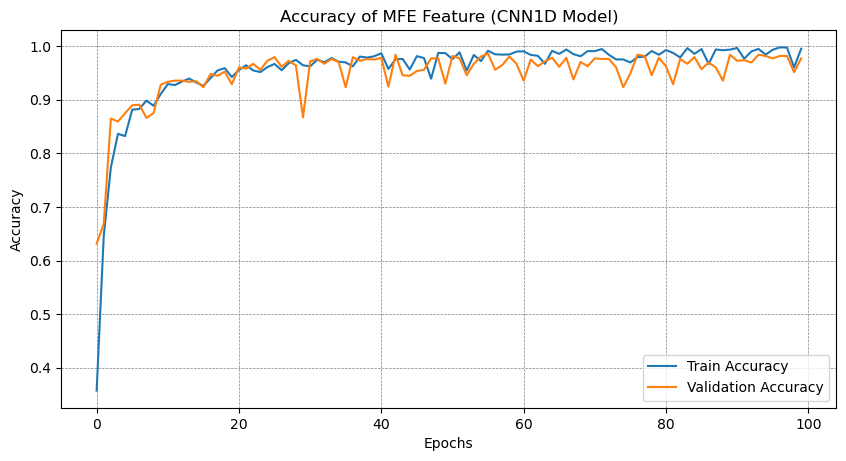

In [10]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["accuracy", "val_accuracy"]])
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy of MFE Feature (CNN1D Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [11]:
# Save the model to disk
# model.save('saved_model')

In [12]:
# train Accuracy and Loss
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.016389, train accuracy: 0.995501
val loss: 0.073447, val accuracy: 0.977528
